# LoFTR Test

In [1]:
import os
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches
import skimage as ski

In [2]:
img_folder = "../leaf-image-sequences/processed/reg/ESWW0070020_1/crop/"
img1_path = img_folder + "20230525_172420_ESWW0070020_1.JPG"
img2_path = img_folder + "20230527_102010_ESWW0070020_1.JPG"
img_last_path = img_folder + "20230608_162957_ESWW0070020_1.JPG"

assert os.path.exists(img1_path) and os.path.exists(img2_path) and os.path.exists(img_last_path), "Invalid path to images"

img1 = K.io.load_image(img1_path, K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image(img2_path, K.io.ImageLoadType.RGB32)[None, ...]
img_last = K.io.load_image(img_last_path, K.io.ImageLoadType.RGB32)[None, ...]

print(f"Img size: {(img1.nelement() * img1.element_size())/1000000} MB")

img1 = K.geometry.resize(img1, (375, 600), antialias=True)
img2 = K.geometry.resize(img2, (375, 600), antialias=True)
img_last = K.geometry.resize(img_last, (375, 600), antialias=True)
# img1 = K.geometry.resize(img1, (375, 600), antialias=False)
# img2 = K.geometry.resize(img2, (375, 600), antialias=False)
# img_last = K.geometry.resize(img_last, (375, 600), antialias=False)

Img size: 201.326592 MB


## Match first and second image

In [3]:
# match with LoFTR
matcher = KF.LoFTR(pretrained="outdoor")

input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),  # LofTR works on grayscale images only
    "image1": K.color.rgb_to_grayscale(img2),
}

with torch.inference_mode():
    correspondences = matcher(input_dict)


# for viewing keys of correspondences dictionary
for k, v in correspondences.items():
    print(k)

keypoints0
keypoints1
confidence
batch_indexes


In [4]:
# select inliers
mkpts0 = correspondences["keypoints0"].cpu().numpy()
mkpts1 = correspondences["keypoints1"].cpu().numpy()
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0
# inliers = inliers <= 0 # plotting outliers

print(f"Total matches: {len(mkpts0)}")
print(f"Inliers: {inliers.sum()} ({inliers.sum()/len(mkpts0):.2%})")

Total matches: 1206
Inliers: 570 (47.26%)


In [5]:
# select points to plot
inliers_t = torch.as_tensor(inliers).flatten() # flatten inliers array and convert to tensor
inlier_idx = torch.nonzero(inliers_t).flatten() # extract indices of True values

N_show = 100
N_show = min(20, inliers.sum())
rand_idx = torch.randperm(len(inlier_idx))[:N_show]  
# show_idx = inlier_idx[rand_idx] # plot subset of inliers
show_idx = torch.randperm(len(mkpts0))[:N_show] # plot subset of *all* matches
mkpts0_show = mkpts0[show_idx]
mkpts1_show = mkpts1[show_idx]
inliers_show = inliers[show_idx]

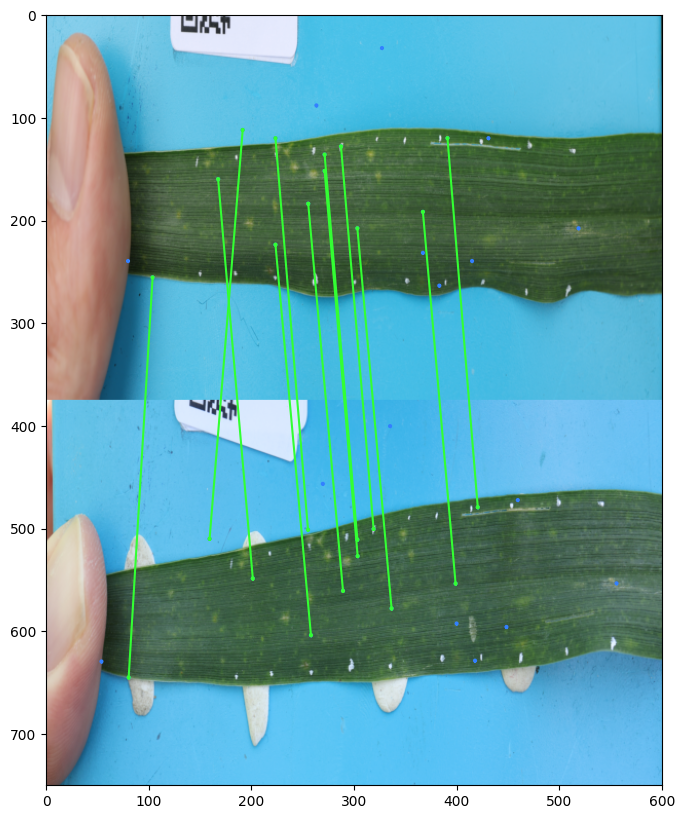

In [6]:
# plot
fig, ax = draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0_show).view(1, -1, 2),
        torch.ones(mkpts0_show.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0_show.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1_show).view(1, -1, 2),
        torch.ones(mkpts1_show.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1_show.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0_show.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers_show,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": None, "feature_color": (0.2, 0.5, 1), "vertical": True},
    return_fig_ax=True
)

# fig.savefig('LeafAlignment/loftr_test.png')
fig.show()

## Plot Confidence

In [7]:
conf_show = correspondences['confidence'][show_idx]

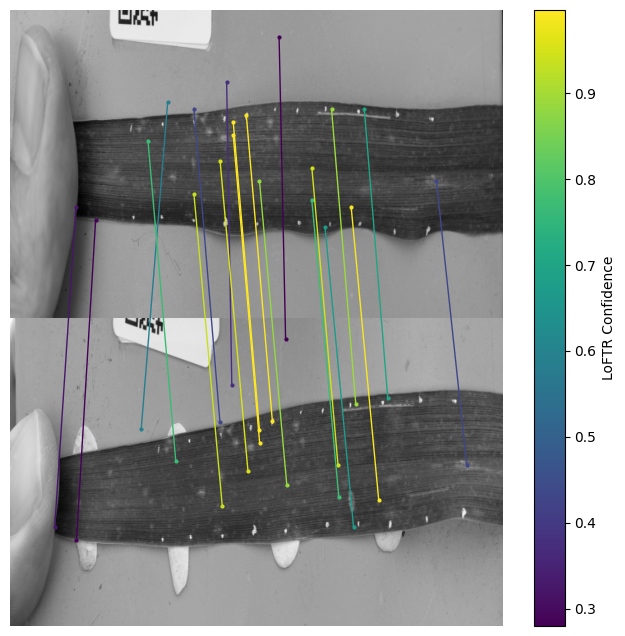

In [8]:
import matplotlib.cm as cm

# img1, img2: C x H x W tensors
img1_gray = K.color.rgb_to_grayscale(img1)  # returns 1 x H x W
img2_gray = K.color.rgb_to_grayscale(img2)

# Convert to numpy
img1_gray_np = img1_gray.squeeze().cpu().numpy()
img2_gray_np = img2_gray.squeeze().cpu().numpy()
img_pair = np.concatenate([img1_gray_np, img2_gray_np], axis=0)


# Prepare figure
# fig, ax = plt.subplots(figsize=(12,6)) # for horizontal plot
fig, ax = plt.subplots(figsize=(8,8)) # for vertical plot
ax.imshow(img_pair, cmap='gray')

# Normalize confidence and map to colormap
conf_norm = (conf_show - conf_show.min()) / (conf_show.max() - conf_show.min())
colors = cm.viridis(conf_norm.cpu().numpy())

# Draw matches
for (x0, y0), (x1, y1), color in zip(mkpts0_show, mkpts1_show, colors):
    # ax.scatter([x0, x1 + img1_gray_np.shape[1]], [y0, y1], color=color, s=2)
    # ax.plot([x0, x1 + img1_gray_np.shape[1]], [y0, y1], color=color, linewidth=1)
    ax.scatter([x0, x1 ], [y0, y1 + img1_gray_np.shape[0]], color=color, s=4)
    ax.plot([x0, x1 ], [y0, y1+ img1_gray_np.shape[0]], color=color, linewidth=1)

ax.axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=conf_show.min(), vmax=conf_show.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('LoFTR Confidence')

plt.show()


## Plot Spatial Coverage

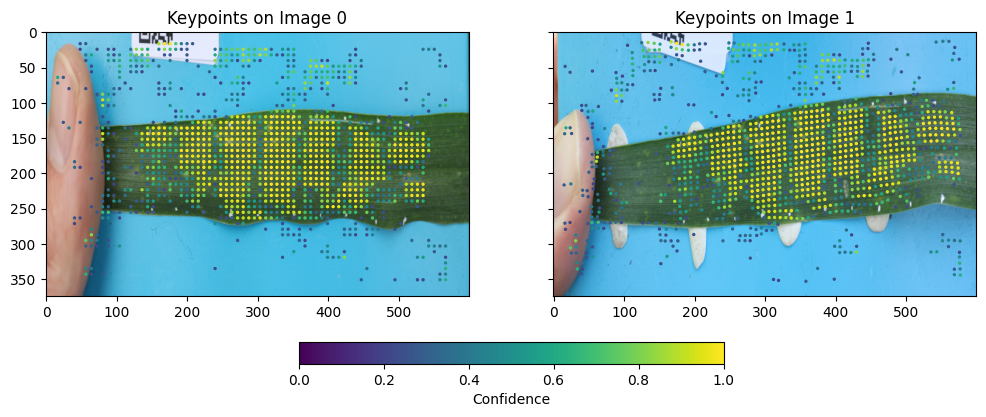

In [ ]:
# plt.figure()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[12, 6], sharex=True, sharey=True)

cmap = 'viridis'

ax1.imshow(img1.squeeze().cpu().permute(1,2,0))
# plt.imshow(img1.cpu())
ax1.scatter(mkpts0[:,0], mkpts0[:,1], s=2, c=correspondences['confidence'], cmap=cmap, vmin=0, vmax=1)
# ax1.scatter(mkpts1[:,0], mkpts1[:,1], s=2, c='blue')
ax1.set_title('Keypoints on Image 0')

ax2.imshow(img2.squeeze().cpu().permute(1,2,0))
# plt.imshow(img1.cpu())
# ax2.scatter(mkpts0[:,0], mkpts0[:,1], s=2, c='lime')
sc2 = ax2.scatter(mkpts1[:,0], mkpts1[:,1], s=2, c=correspondences['confidence'], cmap=cmap, vmin=0, vmax=1)
ax2.set_title('Keypoints on Image 1')

cbar = fig.colorbar(sc2, ax=[ax1, ax2], orientation='horizontal', fraction=0.046, pad=0.1)
cbar.set_label("Confidence")
# fig.colorbar(im, ax=ax2)

## First vs Last Image

In [10]:
# # match with LoFTR
# matcher = KF.LoFTR(pretrained="outdoor")

# input_dict = {
#     "image0": K.color.rgb_to_grayscale(img1),  # LofTR works on grayscale images only
#     "image1": K.color.rgb_to_grayscale(img_last),
# }

# with torch.inference_mode():
#     correspondences = matcher(input_dict)

# # select inliers
# mkpts0_l = correspondences["keypoints0"].cpu().numpy()
# mkpts_l = correspondences["keypoints1"].cpu().numpy()
# Fm, inliers_l = cv2.findFundamentalMat(mkpts0_l, mkpts_l, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
# inliers_l = inliers_l > 0
# # inliers = inliers <= 0 # plotting outliers

# print(f"Total matches: {len(mkpts0_l)}")
# print(f"Inliers: {inliers_l.sum()} ({inliers_l.sum()/len(mkpts0_l):.2%})")

## Thin Plate Spline

In [11]:
thrsld = 0.75
mkpts0[correspondences['confidence'] > thrsld]

array([[159.57446 ,  15.957447],
       [167.55319 ,  15.957447],
       [175.53192 ,  15.957447],
       ...,
       [319.14893 , 263.29788 ],
       [ 63.82979 , 287.23404 ],
       [422.87234 , 319.14893 ]], shape=(578, 2), dtype=float32)

In [12]:
img2_reordered = img2[0].permute(1, 2, 0)

In [23]:
img1_mks = mkpts0[correspondences['confidence'] > thrsld]
img2_mks = mkpts1[correspondences['confidence'] > thrsld]


tps = ski.transform.ThinPlateSplineTransform()
tps.estimate(img1_mks, img2_mks) # estimate transform from img1 -> img2
warped = ski.transform.warp(img2_reordered, tps) # warp uses inverse transform, i.e. img2 -> img1

tps_inv = ski.transform.ThinPlateSplineTransform()
tps_inv.estimate(img2_mks, img1_mks) # estimate transform from img2 → img1
# warped = ski.transform.warp(img2_reordered, inverse_map=tps_inv)
# img1_warped = ski.transform.warp(img2_reordered, inverse_map=tps_inv)
warped_keypts = tps_inv(img2_mks)

In [21]:
# warped_keypts = tps.inverse(img2_mks)
# img2_reordered.shape
warped_keypts.shape

(578, 2)

(np.float64(-0.5), np.float64(599.5), np.float64(374.5), np.float64(-0.5))

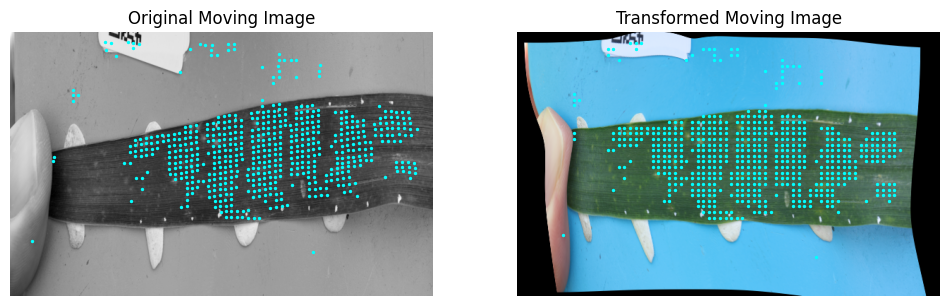

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))

axs[0].imshow(img2_gray_np, cmap='gray')
axs[0].scatter(img2_mks[:, 0], img2_mks[:, 1], s=2, color='cyan')
axs[0].set_title("Original Moving Image")
axs[0].axis('off')
axs[1].imshow(warped, cmap='gray')
# axs[1].scatter(src[:, 0], src[:, 1], s=2, color='cyan')
axs[1].scatter(warped_keypts[:, 0], warped_keypts[:, 1], s=2, color='cyan')
axs[1].set_title("Transformed Moving Image")
axs[1].axis('off')

### Overlay

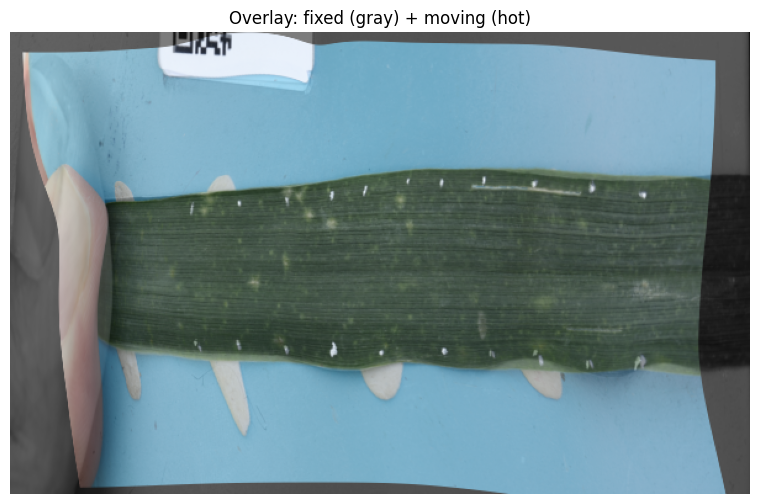

In [23]:
plt.figure(figsize=(12,6))
plt.imshow(img1_gray_np, cmap='gray')
plt.imshow(warped, cmap='hot', alpha=0.5)
plt.title("Overlay: fixed (gray) + moving (hot)")
plt.axis('off')
plt.show()

### Keypoint Alignment

In [ ]:
# Image 1 keypoints vs warped keypoints of image 2:
mae_12 = np.mean(img1_mks - warped_keypts)
print(f"Alignment Error of Keypoint of Image 1 vs Warped Keypoint of Image 2:    {mae_12:.5} (MAE)")

# Image 2 keypoints vs warped keypoints of image 1:
warped_keypts_img1 = tps(img1_mks)
mae_21 = np.mean(img2_mks - warped_keypts_img1)
print(f"Alignment Error of Keypoint of Image 1 vs Warped Keypoint of Image 2:    {mae_21:.5} (MAE)")

Alignment Error of Keypoint of Image 1 vs Warped Keypoint of Image 2:    3.5654e-05 (MAE)
Alignment Error of Keypoint of Image 1 vs Warped Keypoint of Image 2:    3.5987e-06 (MAE)
